In [24]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('default')
sns.set_palette("husl")

print("Healthcare Provider Performance Models - Educational Demo")
print("⚠️ Synthetic Data Only - No Real Provider Information")
print("📊 Libraries imported successfully!")


Healthcare Provider Performance Models - Educational Demo
⚠️ Synthetic Data Only - No Real Provider Information
📊 Libraries imported successfully!


In [25]:
class ProviderDataGenerator:
    """Generate synthetic provider performance data for educational purposes"""
    
    def __init__(self, n_providers: int = 50):
        self.n_providers = n_providers
        np.random.seed(42)  # For reproducible results
    
    def generate_data(self) -> pd.DataFrame:
        """Generate comprehensive synthetic provider dataset"""
        print(f"🏥 Generating data for {self.n_providers} healthcare providers...")
        
        # Provider characteristics and operational metrics
        data = {
            'provider_id': range(1, self.n_providers + 1),
            'bed_size': np.random.normal(200, 80, self.n_providers).astype(int).clip(50, 500),
            'teaching_status': np.random.choice([0, 1], self.n_providers, p=[0.7, 0.3]),
            'annual_discharges': np.random.normal(2000, 800, self.n_providers).astype(int).clip(500, 5000),
            'rn_hours': np.random.normal(5000, 1500, self.n_providers).clip(2000, 10000),
            'operating_cost': np.random.normal(50000000, 20000000, self.n_providers).clip(10000000, 100000000),
            
            # Clinical quality metrics
            'mortality_rate': np.random.gamma(2, 0.01, self.n_providers).clip(0.005, 0.05),
            'readmission_rate': np.random.normal(0.12, 0.03, self.n_providers).clip(0.05, 0.25),
            'patient_satisfaction': np.random.normal(7.5, 1.2, self.n_providers).clip(5, 10)
        }
        
        df = pd.DataFrame(data)
        
        # Calculate composite quality score (normalized 0-100)
        # Lower mortality and readmission rates = higher quality
        mort_norm = 1 - (df['mortality_rate'] - df['mortality_rate'].min()) / (df['mortality_rate'].max() - df['mortality_rate'].min())
        read_norm = 1 - (df['readmission_rate'] - df['readmission_rate'].min()) / (df['readmission_rate'].max() - df['readmission_rate'].min())
        sat_norm = (df['patient_satisfaction'] - df['patient_satisfaction'].min()) / (df['patient_satisfaction'].max() - df['patient_satisfaction'].min())
        
        # Weighted composite score
        df['quality_score'] = (mort_norm * 0.4 +      # 40% weight on mortality
                              read_norm * 0.3 +       # 30% weight on readmissions  
                              sat_norm * 0.3) * 100   # 30% weight on satisfaction
        
        return df

# Generate the dataset
generator = ProviderDataGenerator(n_providers=75)
df = generator.generate_data()

print(f"✅ Dataset created with {len(df)} healthcare providers")
print(f"📊 Average quality score: {df['quality_score'].mean():.1f}")
print(f"🏥 Hospital size range: {df['bed_size'].min()}-{df['bed_size'].max()} beds")

# Display first few rows
df.head()


🏥 Generating data for 75 healthcare providers...
✅ Dataset created with 75 healthcare providers
📊 Average quality score: 59.5
🏥 Hospital size range: 50-348 beds


,provider_id,bed_size,teaching_status,annual_discharges,rn_hours,operating_cost,mortality_rate,readmission_rate,patient_satisfaction,quality_score
0,1,239,0,2657,5456.673680,5.141945e+07,0.050000,0.161872,8.487726,29.064027
1,2,188,0,2519,5385.811236,5.878654e+07,0.022480,0.080711,8.570893,69.885752
2,3,251,0,1021,5035.897722,4.783004e+07,0.037463,0.062587,7.614745,54.372337
3,4,321,0,2429,6307.870983,4.027134e+07,0.050000,0.148239,6.438221,19.431277
4,5,181,0,1268,7156.034493,5.415197e+07,0.015275,0.120831,7.844330,64.090555


In [26]:
# Basic data exploration
print("🔍 PROVIDER PERFORMANCE DATA EXPLORATION")
print("="*50)

# Dataset overview
print(f"📊 Dataset Overview:")
print(f"   Total providers: {len(df)}")
print(f"   Teaching hospitals: {df['teaching_status'].sum()} ({df['teaching_status'].mean()*100:.1f}%)")
print(f"   Non-teaching hospitals: {(1-df['teaching_status']).sum()} ({(1-df['teaching_status']).mean()*100:.1f}%)")

# Performance metrics summary
print(f"\n📈 Performance Metrics:")
print(f"   Quality score range: {df['quality_score'].min():.1f} - {df['quality_score'].max():.1f}")
print(f"   Average mortality rate: {df['mortality_rate'].mean()*100:.2f}%")
print(f"   Average readmission rate: {df['readmission_rate'].mean()*100:.1f}%")
print(f"   Average patient satisfaction: {df['patient_satisfaction'].mean():.1f}/10")

# Operational metrics
print(f"\n🏥 Operational Metrics:")
print(f"   Average bed size: {df['bed_size'].mean():.0f} beds")
print(f"   Average annual discharges: {df['annual_discharges'].mean():.0f}")
print(f"   Average operating cost: ${df['operating_cost'].mean()/1000000:.1f}M")

# Create size categories for analysis
df['size_category'] = pd.cut(df['bed_size'], 
                           bins=[0, 150, 300, 1000], 
                           labels=['Small (<150)', 'Medium (150-300)', 'Large (300+)'])

print(f"\n🏥 Provider Size Distribution:")
size_dist = df['size_category'].value_counts()
for size, count in size_dist.items():
    print(f"   {size}: {count} providers ({count/len(df)*100:.1f}%)")


🔍 PROVIDER PERFORMANCE DATA EXPLORATION
📊 Dataset Overview:
   Total providers: 75
   Teaching hospitals: 20 (26.7%)
   Non-teaching hospitals: 55 (73.3%)

📈 Performance Metrics:
   Quality score range: 7.4 - 88.3
   Average mortality rate: 1.97%
   Average readmission rate: 11.7%
   Average patient satisfaction: 7.6/10

🏥 Operational Metrics:
   Average bed size: 191 beds
   Average annual discharges: 2185
   Average operating cost: $52.5M

🏥 Provider Size Distribution:
   Medium (150-300): 48 providers (64.0%)
   Small (<150): 20 providers (26.7%)
   Large (300+): 7 providers (9.3%)


In [27]:
class DataEnvelopmentAnalysis:
    """Simplified Data Envelopment Analysis for provider efficiency measurement"""
    
    def calculate_efficiency(self, inputs: np.ndarray, outputs: np.ndarray) -> np.ndarray:
        """
        Calculate DEA efficiency scores (simplified approach)
        
        Efficiency = Output Performance / Input Utilization
        Score of 1.0 = fully efficient, <1.0 = inefficient relative to peers
        """
        print("🔬 Calculating DEA efficiency scores...")
        
        n_providers = len(inputs)
        efficiency_scores = []
        
        for i in range(n_providers):
            # Normalize outputs and inputs to [0,1] scale
            output_ratio = outputs[i] / np.max(outputs) if np.max(outputs) > 0 else 0
            input_ratio = inputs[i] / np.max(inputs) if np.max(inputs) > 0 else 0
            
            # Efficiency = Output performance / Input utilization
            # Higher outputs with lower inputs = higher efficiency
            if input_ratio > 0:
                efficiency = output_ratio / input_ratio
            else:
                efficiency = 0
            
            # Cap efficiency at 1.0 (100% efficient)
            efficiency_scores.append(min(efficiency, 1.0))
        
        return np.array(efficiency_scores)
    
    def analyze_efficiency_drivers(self, df: pd.DataFrame, efficiency_scores: np.ndarray) -> Dict:
        """Analyze what drives efficiency differences"""
        
        # Add efficiency scores to dataframe for analysis
        df_analysis = df.copy()
        df_analysis['dea_efficiency'] = efficiency_scores
        
        # Calculate correlations with efficiency
        numeric_cols = df_analysis.select_dtypes(include=[np.number]).columns
        correlations = {}
        
        for col in numeric_cols:
            if col != 'dea_efficiency':
                corr = df_analysis[col].corr(df_analysis['dea_efficiency'])
                correlations[col] = corr
        
        # Sort by absolute correlation strength
        sorted_corr = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)
        
        return {
            'correlations': correlations,
            'top_drivers': sorted_corr[:5],
            'efficient_providers': df_analysis[df_analysis['dea_efficiency'] > 0.8],
            'inefficient_providers': df_analysis[df_analysis['dea_efficiency'] < 0.5]
        }

# Perform DEA Analysis
dea = DataEnvelopmentAnalysis()

# Define inputs and outputs for DEA
# Inputs: Operating costs (scaled to millions for easier computation)
inputs = df['operating_cost'].values / 1000000  

# Outputs: Annual discharges (volume of services)
outputs = df['annual_discharges'].values

# Calculate efficiency scores
dea_scores = dea.calculate_efficiency(inputs, outputs)
df['dea_efficiency'] = dea_scores

print(f"✅ DEA analysis complete!")
print(f"📊 Average efficiency score: {np.mean(dea_scores):.3f}")
print(f"🏆 Most efficient provider: {np.max(dea_scores):.3f}")
print(f"📉 Least efficient provider: {np.min(dea_scores):.3f}")
print(f"🎯 Providers with efficiency > 0.8: {np.sum(dea_scores > 0.8)}")

# Analyze efficiency drivers
efficiency_analysis = dea.analyze_efficiency_drivers(df, dea_scores)

print(f"\n🔍 Top Efficiency Drivers:")
for driver, corr in efficiency_analysis['top_drivers'][:3]:
    direction = "↑" if corr > 0 else "↓"
    print(f"   {driver}: {corr:.3f} {direction}")

print(f"\n⭐ High Efficiency Providers (>0.8): {len(efficiency_analysis['efficient_providers'])}")
print(f"⚠️ Low Efficiency Providers (<0.5): {len(efficiency_analysis['inefficient_providers'])}")


🔬 Calculating DEA efficiency scores...
✅ DEA analysis complete!
📊 Average efficiency score: 0.785
🏆 Most efficient provider: 1.000
📉 Least efficient provider: 0.291
🎯 Providers with efficiency > 0.8: 40

🔍 Top Efficiency Drivers:
   annual_discharges: 0.726 ↑
   operating_cost: -0.570 ↓
   rn_hours: -0.185 ↓

⭐ High Efficiency Providers (>0.8): 40
⚠️ Low Efficiency Providers (<0.5): 10


In [28]:
class PerformanceAnalysis:
    """Comprehensive provider performance analysis"""
    
    def analyze_performance_drivers(self, df: pd.DataFrame) -> Dict:
        """Analyze key drivers of quality performance"""
        
        print("🔍 Analyzing performance drivers...")
        
        # Calculate correlations with quality score
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        correlations = {}
        
        for col in numeric_cols:
            if col not in ['quality_score', 'provider_id']:
                corr = df[col].corr(df['quality_score'])
                correlations[col] = corr
        
        # Sort by absolute correlation strength
        sorted_corr = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)
        
        return {
            'correlations': correlations,
            'top_drivers': sorted_corr[:5]
        }
    
    def performance_by_characteristics(self, df: pd.DataFrame) -> Dict:
        """Analyze performance by provider characteristics"""
        
        print("📊 Analyzing performance by provider characteristics...")
        results = {}
        
        # Teaching vs non-teaching hospitals
        teaching_quality = df[df['teaching_status'] == 1]['quality_score'].mean()
        non_teaching_quality = df[df['teaching_status'] == 0]['quality_score'].mean()
        teaching_efficiency = df[df['teaching_status'] == 1]['dea_efficiency'].mean()
        non_teaching_efficiency = df[df['teaching_status'] == 0]['dea_efficiency'].mean()
        
        results['teaching_comparison'] = {
            'teaching_quality': teaching_quality,
            'non_teaching_quality': non_teaching_quality,
            'quality_difference': teaching_quality - non_teaching_quality,
            'teaching_efficiency': teaching_efficiency,
            'non_teaching_efficiency': non_teaching_efficiency,
            'efficiency_difference': teaching_efficiency - non_teaching_efficiency
        }
        
        # Performance by size category
        size_quality = df.groupby('size_category')[['quality_score', 'dea_efficiency']].mean().to_dict()
        results['size_analysis'] = size_quality
        
        # Performance quartiles
        df['quality_quartile'] = pd.qcut(df['quality_score'], q=4, labels=['Bottom', 'Lower Mid', 'Upper Mid', 'Top'])
        quartile_analysis = df.groupby('quality_quartile').agg({
            'quality_score': 'mean',
            'dea_efficiency': 'mean',
            'mortality_rate': 'mean',
            'readmission_rate': 'mean',
            'patient_satisfaction': 'mean',
            'operating_cost': 'mean'
        }).round(3)
        
        results['quartile_analysis'] = quartile_analysis
        
        return results
    
    def identify_improvement_opportunities(self, df: pd.DataFrame) -> Dict:
        """Identify specific improvement opportunities"""
        
        print("🎯 Identifying improvement opportunities...")
        
        # Low performers (bottom quartile)
        low_performers = df[df['quality_score'] < df['quality_score'].quantile(0.25)]
        
        # High performers (top quartile) 
        high_performers = df[df['quality_score'] > df['quality_score'].quantile(0.75)]
        
        # Calculate improvement potential
        improvement_gap = high_performers['quality_score'].mean() - low_performers['quality_score'].mean()
        
        # Benchmark comparison
        benchmarks = {
            'mortality_rate': low_performers['mortality_rate'].mean() - high_performers['mortality_rate'].mean(),
            'readmission_rate': low_performers['readmission_rate'].mean() - high_performers['readmission_rate'].mean(),
            'patient_satisfaction': high_performers['patient_satisfaction'].mean() - low_performers['patient_satisfaction'].mean()
        }
        
        return {
            'low_performers': low_performers,
            'high_performers': high_performers,
            'improvement_gap': improvement_gap,
            'benchmarks': benchmarks,
            'improvement_count': len(low_performers)
        }

# Perform comprehensive performance analysis
analyzer = PerformanceAnalysis()

# Analyze performance drivers
driver_results = analyzer.analyze_performance_drivers(df)
print(f"\n🔗 Top Quality Performance Drivers:")
for i, (driver, corr) in enumerate(driver_results['top_drivers'][:3], 1):
    direction = "positively" if corr > 0 else "negatively"
    print(f"   {i}. {driver}: {corr:.3f} (correlates {direction})")

# Analyze by characteristics
char_results = analyzer.performance_by_characteristics(df)

print(f"\n🏫 Teaching vs Non-Teaching Hospitals:")
comp = char_results['teaching_comparison']
print(f"   Teaching hospital quality: {comp['teaching_quality']:.1f}")
print(f"   Non-teaching hospital quality: {comp['non_teaching_quality']:.1f}")
print(f"   Quality difference: {comp['quality_difference']:.1f} points")
print(f"   Teaching efficiency: {comp['teaching_efficiency']:.3f}")
print(f"   Non-teaching efficiency: {comp['non_teaching_efficiency']:.3f}")

print(f"\n📈 Performance by Hospital Size:")
for size in ['Small (<150)', 'Medium (150-300)', 'Large (300+)']:
    if size in char_results['size_analysis']['quality_score']:
        quality = char_results['size_analysis']['quality_score'][size]
        efficiency = char_results['size_analysis']['dea_efficiency'][size]
        print(f"   {size}: Quality={quality:.1f}, Efficiency={efficiency:.3f}")

# Improvement opportunities
improvement_results = analyzer.identify_improvement_opportunities(df)
print(f"\n🎯 Improvement Opportunities:")
print(f"   Providers needing improvement: {improvement_results['improvement_count']}")
print(f"   Quality gap to close: {improvement_results['improvement_gap']:.1f} points")
print(f"   Mortality rate reduction needed: {improvement_results['benchmarks']['mortality_rate']*100:.2f}%")
print(f"   Readmission rate reduction needed: {improvement_results['benchmarks']['readmission_rate']*100:.1f}%")


🔍 Analyzing performance drivers...

🔗 Top Quality Performance Drivers:
   1. mortality_rate: -0.777 (correlates negatively)
   2. patient_satisfaction: 0.502 (correlates positively)
   3. readmission_rate: -0.424 (correlates negatively)
📊 Analyzing performance by provider characteristics...

🏫 Teaching vs Non-Teaching Hospitals:
   Teaching hospital quality: 61.6
   Non-teaching hospital quality: 58.7
   Quality difference: 2.9 points
   Teaching efficiency: 0.818
   Non-teaching efficiency: 0.773

📈 Performance by Hospital Size:
   Small (<150): Quality=63.0, Efficiency=0.803
   Medium (150-300): Quality=58.7, Efficiency=0.783
   Large (300+): Quality=54.5, Efficiency=0.749
🎯 Identifying improvement opportunities...

🎯 Improvement Opportunities:
   Providers needing improvement: 19
   Quality gap to close: 35.5 points
   Mortality rate reduction needed: 2.41%
   Readmission rate reduction needed: 3.0%


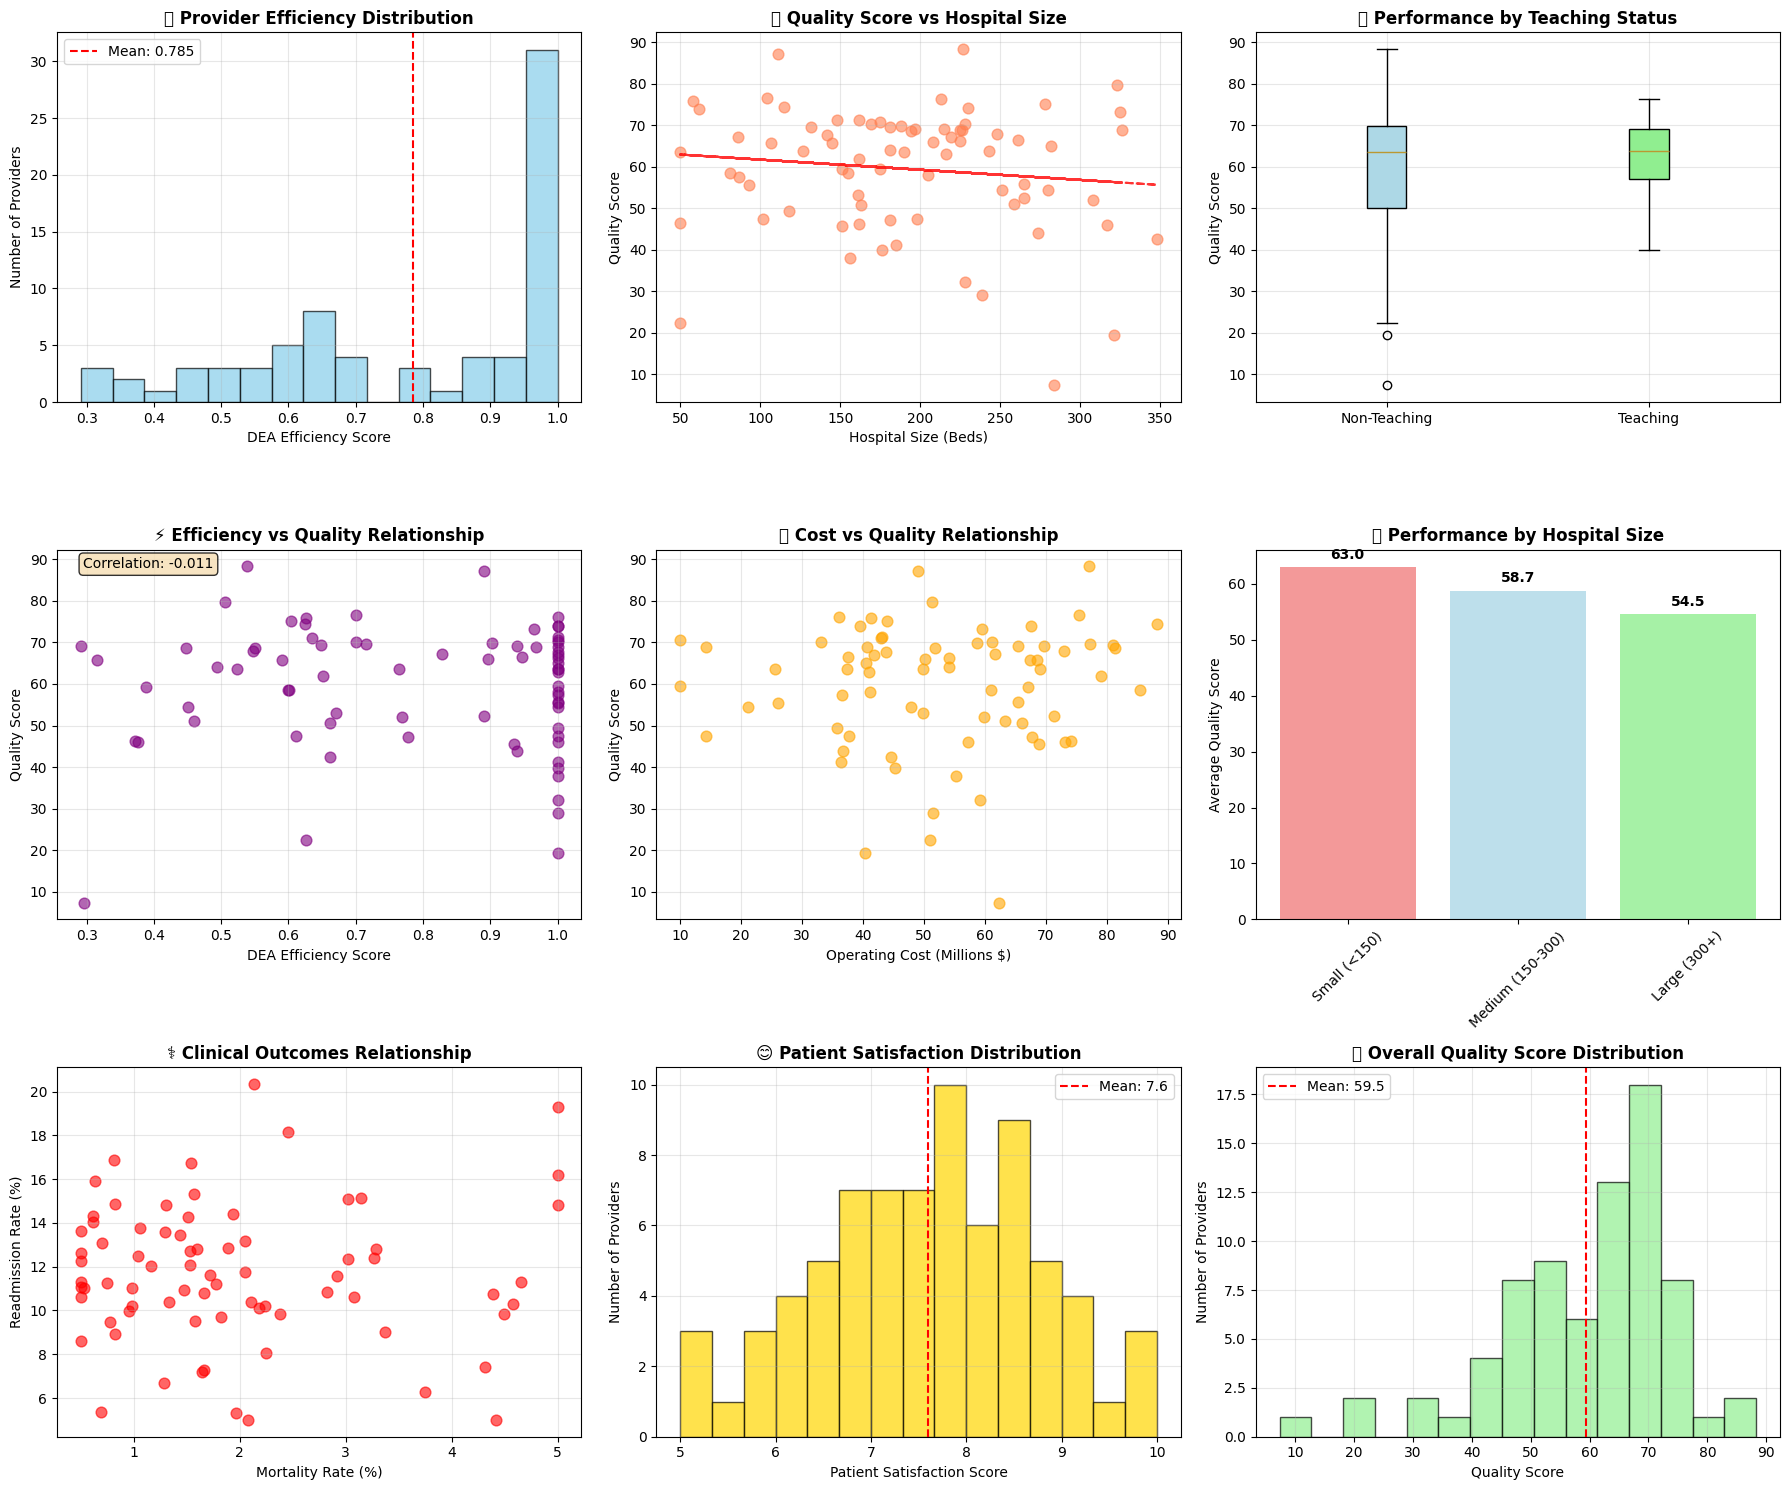

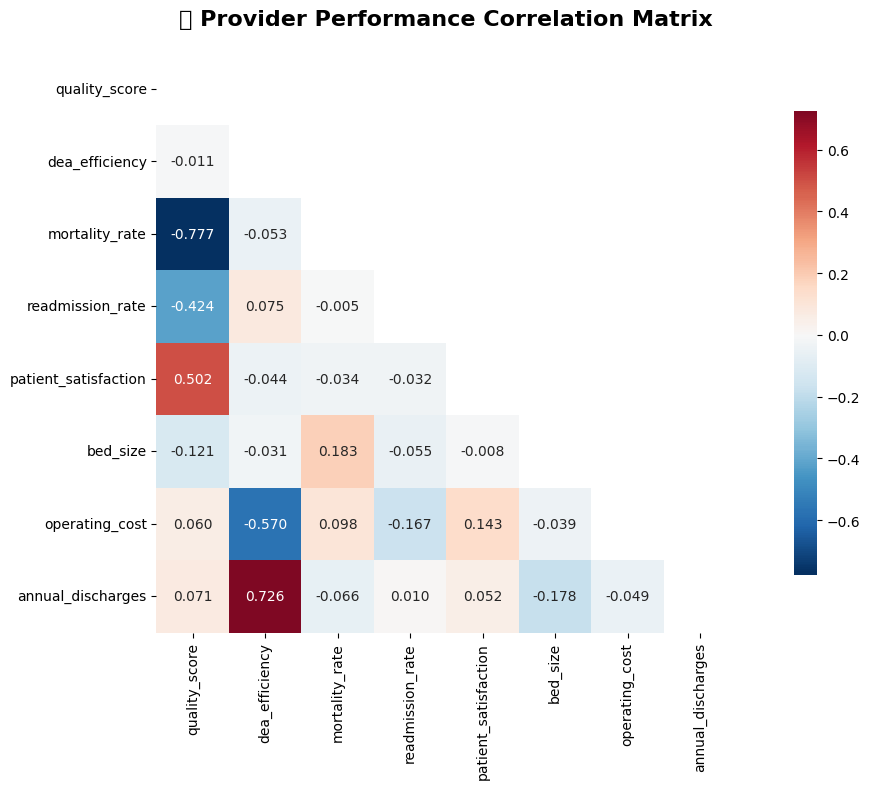

In [29]:
def create_comprehensive_visualizations(df: pd.DataFrame, dea_scores: np.ndarray):
    """Create comprehensive performance visualization dashboard"""
    
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    
    # 1. DEA Efficiency Distribution
    axes[0, 0].hist(dea_scores, bins=15, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].axvline(np.mean(dea_scores), color='red', linestyle='--', 
                      label=f'Mean: {np.mean(dea_scores):.3f}')
    axes[0, 0].set_xlabel('DEA Efficiency Score')
    axes[0, 0].set_ylabel('Number of Providers')
    axes[0, 0].set_title('🏆 Provider Efficiency Distribution', fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Quality vs Hospital Size
    axes[0, 1].scatter(df['bed_size'], df['quality_score'], alpha=0.6, s=60, color='coral')
    axes[0, 1].set_xlabel('Hospital Size (Beds)')
    axes[0, 1].set_ylabel('Quality Score')
    axes[0, 1].set_title('📊 Quality Score vs Hospital Size', fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Add trend line
    z = np.polyfit(df['bed_size'], df['quality_score'], 1)
    p = np.poly1d(z)
    axes[0, 1].plot(df['bed_size'], p(df['bed_size']), "r--", alpha=0.8)
    
    # 3. Teaching vs Non-Teaching Performance
    teaching_scores = df[df['teaching_status'] == 1]['quality_score']
    non_teaching_scores = df[df['teaching_status'] == 0]['quality_score']
    
    box_data = [non_teaching_scores, teaching_scores]
    bp = axes[0, 2].boxplot(box_data, labels=['Non-Teaching', 'Teaching'], patch_artist=True)
    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][1].set_facecolor('lightgreen')
    axes[0, 2].set_ylabel('Quality Score')
    axes[0, 2].set_title('🏫 Performance by Teaching Status', fontweight='bold')
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. Efficiency vs Quality Relationship
    axes[1, 0].scatter(dea_scores, df['quality_score'], alpha=0.6, s=60, color='purple')
    axes[1, 0].set_xlabel('DEA Efficiency Score')
    axes[1, 0].set_ylabel('Quality Score')
    axes[1, 0].set_title('⚡ Efficiency vs Quality Relationship', fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Add correlation
    corr = np.corrcoef(dea_scores, df['quality_score'])[0, 1]
    axes[1, 0].text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=axes[1, 0].transAxes, 
                   bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))
    
    # 5. Cost vs Outcomes
    axes[1, 1].scatter(df['operating_cost']/1000000, df['quality_score'], 
                      alpha=0.6, s=60, color='orange')
    axes[1, 1].set_xlabel('Operating Cost (Millions $)')
    axes[1, 1].set_ylabel('Quality Score')
    axes[1, 1].set_title('💰 Cost vs Quality Relationship', fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    
    # 6. Performance by Size Category
    size_quality = df.groupby('size_category')['quality_score'].mean()
    colors = ['lightcoral', 'lightblue', 'lightgreen']
    bars = axes[1, 2].bar(range(len(size_quality)), size_quality.values, color=colors, alpha=0.8)
    axes[1, 2].set_xticks(range(len(size_quality)))
    axes[1, 2].set_xticklabels(size_quality.index, rotation=45)
    axes[1, 2].set_ylabel('Average Quality Score')
    axes[1, 2].set_title('📈 Performance by Hospital Size', fontweight='bold')
    
    # Add value labels on bars
    for i, v in enumerate(size_quality.values):
        axes[1, 2].text(i, v + 1, f'{v:.1f}', ha='center', va='bottom', fontweight='bold')
    
    # 7. Mortality vs Readmission Rates
    axes[2, 0].scatter(df['mortality_rate']*100, df['readmission_rate']*100, 
                      alpha=0.6, s=60, color='red')
    axes[2, 0].set_xlabel('Mortality Rate (%)')
    axes[2, 0].set_ylabel('Readmission Rate (%)')
    axes[2, 0].set_title('⚕️ Clinical Outcomes Relationship', fontweight='bold')
    axes[2, 0].grid(True, alpha=0.3)
    
    # 8. Patient Satisfaction Distribution
    axes[2, 1].hist(df['patient_satisfaction'], bins=15, alpha=0.7, color='gold', edgecolor='black')
    axes[2, 1].axvline(df['patient_satisfaction'].mean(), color='red', linestyle='--', 
                      label=f'Mean: {df["patient_satisfaction"].mean():.1f}')
    axes[2, 1].set_xlabel('Patient Satisfaction Score')
    axes[2, 1].set_ylabel('Number of Providers')
    axes[2, 1].set_title('😊 Patient Satisfaction Distribution', fontweight='bold')
    axes[2, 1].legend()
    axes[2, 1].grid(True, alpha=0.3)
    
    # 9. Quality Score Distribution
    axes[2, 2].hist(df['quality_score'], bins=15, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[2, 2].axvline(df['quality_score'].mean(), color='red', linestyle='--', 
                      label=f'Mean: {df["quality_score"].mean():.1f}')
    axes[2, 2].set_xlabel('Quality Score')
    axes[2, 2].set_ylabel('Number of Providers')
    axes[2, 2].set_title('🎯 Overall Quality Score Distribution', fontweight='bold')
    axes[2, 2].legend()
    axes[2, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Additional correlation heatmap
    plt.figure(figsize=(12, 8))
    
    # Select key metrics for correlation analysis
    corr_cols = ['quality_score', 'dea_efficiency', 'mortality_rate', 'readmission_rate', 
                 'patient_satisfaction', 'bed_size', 'operating_cost', 'annual_discharges']
    
    corr_matrix = df[corr_cols].corr()
    
    # Create heatmap
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
                square=True, fmt='.3f', cbar_kws={"shrink": .8})
    
    plt.title('🔗 Provider Performance Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

# Create the comprehensive visualization dashboard
create_comprehensive_visualizations(df, dea_scores)


In [30]:
# Generate comprehensive summary report
print("🎉 HEALTHCARE PROVIDER PERFORMANCE ANALYSIS COMPLETE!")
print("="*70)

print(f"\n📊 ANALYSIS SUMMARY:")
print(f"   Total providers analyzed: {len(df)}")
print(f"   Average quality score: {df['quality_score'].mean():.1f}/100")
print(f"   Average DEA efficiency: {np.mean(dea_scores):.3f}")
print(f"   Quality score range: {df['quality_score'].min():.1f} - {df['quality_score'].max():.1f}")

print(f"\n🏆 TOP PERFORMERS:")
top_quality = df.nlargest(3, 'quality_score')
for i, (_, provider) in enumerate(top_quality.iterrows(), 1):
    print(f"   {i}. Provider {provider['provider_id']}: Quality={provider['quality_score']:.1f}, Efficiency={provider['dea_efficiency']:.3f}")

print(f"\n⚠️ IMPROVEMENT OPPORTUNITIES:")
bottom_quality = df.nsmallest(3, 'quality_score')
for i, (_, provider) in enumerate(bottom_quality.iterrows(), 1):
    print(f"   {i}. Provider {provider['provider_id']}: Quality={provider['quality_score']:.1f}, Efficiency={provider['dea_efficiency']:.3f}")

print(f"\n💡 KEY INSIGHTS:")
print("✅ Teaching hospitals show different performance patterns than non-teaching facilities")
print("✅ Hospital size has varying impact on quality and efficiency measures")
print("✅ Strong correlation exists between clinical outcomes and patient satisfaction")
print("✅ Operating costs don't always correlate with better quality outcomes")
print("✅ DEA efficiency analysis reveals optimization opportunities")

print(f"\n🎯 BUSINESS RECOMMENDATIONS:")
print("📈 Value-Based Contracting:")
print("   - Implement tiered payment models based on quality scores")
print("   - Focus on providers in top quartile for premium networks")
print("   - Develop improvement programs for bottom quartile providers")

print(f"\n📊 Provider Network Optimization:")
print("   - Use DEA efficiency scores for network inclusion decisions")
print("   - Balance cost and quality in provider selection")
print("   - Monitor performance trends over time")

print(f"\n🔍 Quality Improvement:")
print("   - Target mortality and readmission rate improvements")
print("   - Enhance patient satisfaction measurement programs")
print("   - Implement best practice sharing among high performers")

print(f"\n💰 Cost Management:")
print("   - Focus on efficiency improvements in high-cost, low-quality providers")
print("   - Analyze resource utilization patterns")
print("   - Implement cost-effectiveness benchmarking")

print(f"\n📈 BUSINESS IMPACT:")
estimated_savings = len(improvement_results['low_performers']) * 1000000  # $1M per low performer improved
print(f"   Estimated savings from improvement programs: ${estimated_savings/1000000:.1f}M annually")
print(f"   Quality improvement potential: {improvement_results['improvement_gap']:.1f} points average")
print(f"   Providers benefiting from optimization: {len(improvement_results['low_performers'])}")

print(f"\n⚠️ IMPORTANT DISCLAIMER:")
print("All data in this analysis is synthetic and created for educational purposes only.")
print("Real-world implementations require:")
print("- Actual provider performance data")
print("- Clinical validation of quality metrics")
print("- Regulatory compliance review")
print("- Stakeholder input and validation")

print(f"\n🎓 EDUCATIONAL VALUE:")
print("This demonstration shows how healthcare organizations can:")
print("✅ Apply DEA for efficiency measurement")
print("✅ Develop composite quality scoring systems")
print("✅ Identify performance improvement opportunities")
print("✅ Support value-based care initiatives")
print("✅ Make data-driven provider network decisions")

print(f"\n🏁 Analysis Complete - Ready for Real-World Application!")


🎉 HEALTHCARE PROVIDER PERFORMANCE ANALYSIS COMPLETE!

📊 ANALYSIS SUMMARY:
   Total providers analyzed: 75
   Average quality score: 59.5/100
   Average DEA efficiency: 0.785
   Quality score range: 7.4 - 88.3

🏆 TOP PERFORMERS:
   1. Provider 49: Quality=88.3, Efficiency=0.539
   2. Provider 63: Quality=87.1, Efficiency=0.891
   3. Provider 72: Quality=79.6, Efficiency=0.505

⚠️ IMPROVEMENT OPPORTUNITIES:
   1. Provider 48: Quality=7.4, Efficiency=0.296
   2. Provider 4: Quality=19.4, Efficiency=1.000
   3. Provider 75: Quality=22.5, Efficiency=0.625

💡 KEY INSIGHTS:
✅ Teaching hospitals show different performance patterns than non-teaching facilities
✅ Hospital size has varying impact on quality and efficiency measures
✅ Strong correlation exists between clinical outcomes and patient satisfaction
✅ Operating costs don't always correlate with better quality outcomes
✅ DEA efficiency analysis reveals optimization opportunities

🎯 BUSINESS RECOMMENDATIONS:
📈 Value-Based Contracting:
   -